In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [4]:
import os
import pandas as pd

def process_runs(df):
    """
    Split a single DataFrame of 3×388 rows into run1/run2/run3,
    drop the other-run columns, merge on patient_loc, and compute avg_resp_prob.
    """
    run_dfs = []
    # each run has exactly 388 rows
    splits = [(0, 388), (388, 776), (776, 1164)]
    
    for i, (start, end) in enumerate(splits, start=1):
        sub = df.iloc[start:end].reset_index(drop=True)
        # drop columns for the *other* runs
        to_drop = [
            col for col in sub.columns 
            if any(col.endswith(f"_run{j}") for j in (1,2,3) if j != i)
        ]
        sub = sub.drop(columns=to_drop)
        # normalize patient_loc so merges work
        sub["patient_loc"] = sub["patient_loc"].astype(str).str.strip()
        run_dfs.append(sub)
    
    # outer-merge run1 ← run2 ← run3 on patient_loc
    merged = run_dfs[0].merge(run_dfs[1], on="patient_loc", how="outer") \
                      .merge(run_dfs[2], on="patient_loc", how="outer")
    
    # compute average responder probability
    merged["avg_resp_prob"] = (
        merged["prob_resp_run1"] +
        merged["prob_resp_run2"] +
        merged["prob_resp_run3"]
    ) / 3.0
    
    return merged

def load_and_process_sim_data(
    base_dir,
    openhrs,
    cfrs_main,
    cfrs_all
):
    """
    Load all sim CSVs for:
      – aedYes (cfr in cfrs_main) under base_dir/Data/sim_runs
      – aedall_all_aeds (cfr in cfrs_all) in base_dir
    then apply process_runs() to each and stash in a dict.
    """
    processed = {}
    
    # first the aedYes files in Data/sim_runs
    for openhr in openhrs:
        for cfr in cfrs_main:
            fname = (
                f"sim_results_openhr{openhr}"
                f"_cfr{cfr}_maxresp100_numsim3_aedYes.csv"
            )
            path = os.path.join(base_dir, "Data", "sim_runs", fname)
            if not os.path.exists(path):
                print(f"⚠️ missing: {path}")
                continue
            df = pd.read_csv(path)
            df_proc = process_runs(df)
            df_proc["openhr"] = openhr
            df_proc["cfr"]    = cfr
            df_proc["aed"]    = "Yes"
            processed[(openhr, cfr, "aedYes")] = df_proc
    
    # then the aedall_all_aeds files at top level
    for openhr in openhrs:
        for cfr in cfrs_all:
            fname = (
                f"sim_results_openhr{openhr}"
                f"_cfr{cfr}_maxresp100_numsim3_aedall_all_aeds.csv"
            )
            path = os.path.join(base_dir, fname)
            if not os.path.exists(path):
                print(f"⚠️ missing: {path}")
                continue
            df = pd.read_csv(path)
            df_proc = process_runs(df)
            df_proc["openhr"] = openhr
            df_proc["cfr"]    = cfr
            df_proc["aed"]    = "all"
            processed[(openhr, cfr, "aedall")] = df_proc

    return processed




In [34]:
# — Usage example —

openhrs     = [2.0, 8.0, 14.0, 20.0]
cfrs_main   = [0.001,0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.03]
cfrs_all    = [0.005]
base_folder = "."   # or wherever your files live

all_data = load_and_process_sim_data(base_folder, openhrs, cfrs_main, cfrs_all)

# Access one processed DataFrame by its key:
df_8_0p0175 = all_data[(8.0, 0.0175, "aedYes")]
# Load AED=All simulations

⚠️ missing: .\sim_results_openhr2.0_cfr0.005_maxresp100_numsim3_aedall_all_aeds.csv
⚠️ missing: .\sim_results_openhr8.0_cfr0.005_maxresp100_numsim3_aedall_all_aeds.csv
⚠️ missing: .\sim_results_openhr14.0_cfr0.005_maxresp100_numsim3_aedall_all_aeds.csv
⚠️ missing: .\sim_results_openhr20.0_cfr0.005_maxresp100_numsim3_aedall_all_aeds.csv


In [16]:
df_8_0p0175

,patient_loc,responder_loc_run1,duration_Responder_run1,Indirect_Responder_loc_run1,aed_loc_run1,duration_AED_run1,vector_loc_run1,duration_Vector_run1,prob_vec_run1,prob_resp_run1,...,prob_resp_run3,filter_values_run3,opening_hour_run3,decline_rate_run3,max_number_responder_run3,proportion_of_CFR_run3,avg_resp_prob,openhr,cfr,aed
0,"(4.724486, 50.875134)","(4.723587137795002, 50.87476340725809)",53.90,No AED,No AED,10000.00,"(4.7243436, 50.8696549)",641.37,0.324247,0.675110,...,0.556319,Yes,8.0,0.7,100.0,0.0175,0.607939,8.0,0.0175,Yes
1,"(4.663458, 50.872624)","(4.66539880932413, 50.87278197835262)",104.51,No AED,No AED,10000.00,"(4.6658621, 50.8774603)",621.19,0.335943,0.640302,...,0.623104,Yes,8.0,0.7,100.0,0.0175,0.643393,8.0,0.0175,Yes
2,"(4.706287, 50.868107)","(4.707005108086147, 50.86706420046502)",96.88,"(4.711448100931423, 50.86821935346448)","(4.7116128, 50.867677)",452.43,"(4.6998331, 50.8723536)",618.41,0.337587,0.704253,...,0.337587,Yes,8.0,0.7,100.0,0.0175,0.459809,8.0,0.0175,Yes
3,"(4.729334, 50.886379)","(4.729587811859186, 50.887819737644506)",168.23,No AED,No AED,10000.00,"(4.7243436, 50.8696549)",1978.53,0.030983,0.296883,...,0.355163,Yes,8.0,0.7,100.0,0.0175,0.299361,8.0,0.0175,Yes
4,"(4.7093, 50.870361)",No responder,10000.00,No AED,No AED,10000.00,"(4.6998331, 50.8723536)",750.80,0.267560,0.267560,...,0.267560,Yes,8.0,0.7,100.0,0.0175,0.424074,8.0,0.0175,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,"(4.692054, 50.883744)","(4.692216534612377, 50.88429908009593)",48.25,No AED,No AED,10000.00,"(4.6953981, 50.8785355)",612.09,0.341354,0.690070,...,0.658436,Yes,8.0,0.7,100.0,0.0175,0.673635,8.0,0.0175,Yes
384,"(4.676329, 50.867263)","(4.678212725098257, 50.86689917829996)",113.50,No AED,No AED,10000.00,"(4.6658621, 50.8774603)",1466.98,0.076075,0.412134,...,0.412134,Yes,8.0,0.7,100.0,0.0175,0.408986,8.0,0.0175,Yes
385,"(4.676351, 50.870025)","(4.674696304403341, 50.87281116192789)",317.16,No AED,No AED,10000.00,"(4.6658621, 50.8774603)",934.56,0.193768,0.418800,...,0.577514,Yes,8.0,0.7,100.0,0.0175,0.530081,8.0,0.0175,Yes
386,"(4.71405, 50.873746)","(4.713780064400178, 50.87372854963348)",18.96,"(4.711448100931423, 50.86821935346448)","(4.7116128, 50.867677)",658.86,"(4.7243436, 50.8696549)",693.89,0.295680,0.698974,...,0.295680,Yes,8.0,0.7,100.0,0.0175,0.430112,8.0,0.0175,Yes


In [53]:
import matplotlib.pyplot as plt
def line_plot(time, prop, aed_style, all_data):
    
    for i in time:
        x_vals = []
        y_vals = []
        

        for j in prop:
            df = all_data[(i, j, aed_style)]
            mean = df["avg_resp_prob"].mean()
            proportion = df["proportion_of_CFR_run1"].mean()
            x_vals.append(proportion)
            y_vals.append(mean)
            
        plt.plot(x_vals, y_vals, linestyle='-', marker='o', label = f'Simulation at time: {i}')

    plt.xlabel("Proportion of CFRs")
    plt.ylabel("Average Survival Probability")
    plt.title("Line Plot of Mean vs Proportion")
    plt.legend()
    plt.show()

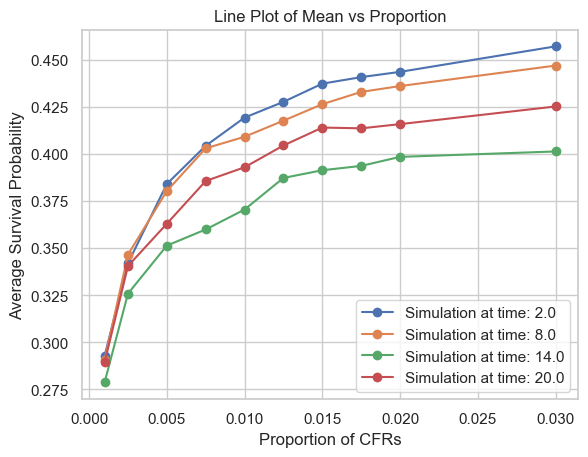

In [54]:
line_plot([2.0,8.0,14.0,20.0],[0.001,0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.03],"aedYes", all_data)

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def line_plot_seaborn(time, prop, aed_style, all_data):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))

    cmap = plt.colormaps["Blues"]
    start, stop = 0.4, 1.0
    colors = [cmap(start + (stop - start) * (i / (len(time) - 1))) for i in range(len(time))]

    for idx, i in enumerate(time):
        x_vals = []
        y_vals = []


        for j in prop:
            df = all_data[(i, j, aed_style)]
            mean = df["avg_resp_prob"].mean()
            proportion = df["proportion_of_CFR_run1"].mean()
            x_vals.append(proportion)
            y_vals.append(mean)
            
        sns.lineplot(x=x_vals, y=y_vals, label=f'Simulation at time: {i}', marker='o', color=colors[idx])

    plt.xlabel("Proportion of CFRs", fontsize=12)
    plt.ylabel("Average Survival Probability", fontsize=12)
    plt.title("Average Survival Probability vs CFR Proportion", fontsize=14)
    plt.legend(title="Scenario", fontsize=10, title_fontsize=11)
    plt.tight_layout()
    plt.show()

c:\Users\leonw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\leonw\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

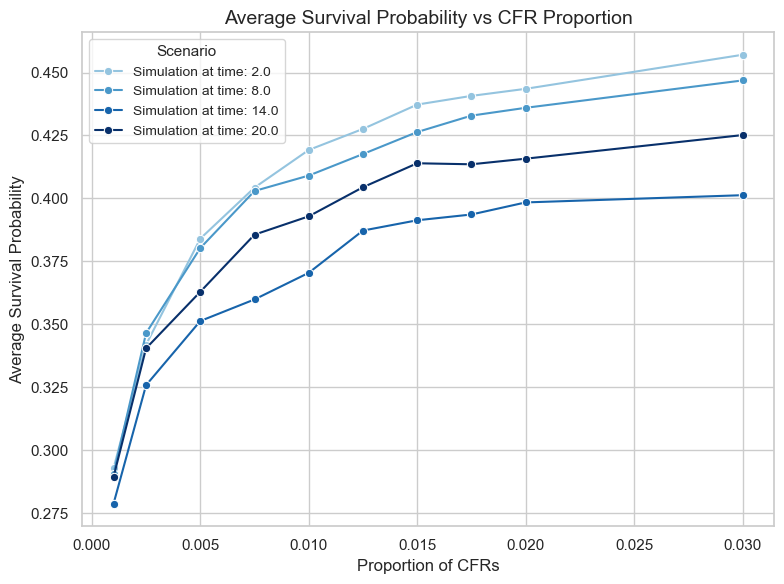

In [56]:
line_plot_seaborn([2.0,8.0,14.0,20.0],[0.001,0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.03],"aedYes", all_data)

In [78]:
df_8_0p0175.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_loc                  388 non-null    object 
 1   responder_loc_run1           388 non-null    object 
 2   duration_Responder_run1      388 non-null    float64
 3   Indirect_Responder_loc_run1  388 non-null    object 
 4   aed_loc_run1                 388 non-null    object 
 5   duration_AED_run1            388 non-null    float64
 6   vector_loc_run1              388 non-null    object 
 7   duration_Vector_run1         388 non-null    float64
 8   prob_vec_run1                388 non-null    float64
 9   prob_resp_run1               388 non-null    float64
 10  filter_values_run1           388 non-null    object 
 11  opening_hour_run1            388 non-null    float64
 12  decline_rate_run1            388 non-null    float64
 13  max_number_responder

In [80]:
#[0.001,0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.03]
df_20_0p0175 = all_data[(20.0, 0.0175, "aedYes")]
df_filtered = df_20_0p0175[df_20_0p0175['duration_AED_run1']<9000]
print(len(df_filtered[df_filtered['duration_AED_run1']<df_filtered['duration_Vector_run1']]))

df_20_0p001 = all_data[(20.0, 0.001, "aedYes")]
df_filtered_2 = df_20_0p001[df_20_0p001['duration_AED_run1']<9000]
print(len(df_filtered_2[df_filtered_2['duration_AED_run1']<df_filtered_2['duration_Vector_run1']]))

df_20_0p03 = all_data[(20.0, 0.03, "aedYes")]
df_filtered_3 = df_20_0p03[df_20_0p03['duration_AED_run1']<9000]
print(len(df_filtered_3[df_filtered_3['duration_AED_run1']<df_filtered_3['duration_Vector_run1']]))

df_20_0p005 = all_data[(20.0, 0.005, "aedYes")]
df_filtered_4 = df_20_0p005[df_20_0p005['duration_AED_run1']<9000]
print(len(df_filtered_4[df_filtered_4['duration_AED_run1']<df_filtered_4['duration_Vector_run1']]))

37
12
36
22


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def radial_bar_aeds_by_hour(hours, prop, style, all_data):
    runs = ['duration_AED_run1', 'duration_AED_run2', 'duration_AED_run3']
    labels = []
    values = []
    theta = []
    bar_colors = []

    # Base colors for each hour
    base_colors = plt.colormaps['tab10'](np.linspace(0, 1, len(hours)))
    gap = 0.1  # radians of empty space between hours
    bar_width = (2 * np.pi - gap * len(hours)) / (len(hours) * len(runs))

    current_angle = 0

    for hour_idx, hour in enumerate(hours):
        base_color = base_colors[hour_idx]

        for run_idx, run in enumerate(runs):
            df = all_data[(hour, prop, style)]
            df_filtered = df[df[run] < 9000]
            count = len(df_filtered[df_filtered[run]<df_filtered['duration_Vector_run1']])
            values.append(count)

            angle = current_angle
            theta.append(angle)
            current_angle += bar_width

            # Slightly modify alpha for shading per run
            alpha = 0.6 + 0.2 * run_idx
            color = mcolors.to_rgba(base_color, alpha=alpha)
            bar_colors.append(color)

            labels.append(f"{hour}:00\n{run[-1]}")  # e.g., "8:00\n1"

        current_angle += gap  # add spacing between hours

    # Plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
    bars = ax.bar(theta, values, width=bar_width, color=bar_colors, edgecolor='black')

   # Add value labels
    for angle, bar, value in zip(theta, bars, values):
        radius = bar.get_height()
        offset = 0.4 if radius < 5 else -0.5  # dynamic label position
        rotation = np.rad2deg(angle)

        # Flip upside-down labels on left half of the plot
        if np.pi/2 < angle < 3*np.pi/2:
            alignment = 'right'
            rotation += 180
        else:
            alignment = 'left'

        ax.text(angle, radius + offset, f"{value}", ha=alignment, va='center',
                fontsize=9, color='black', rotation=rotation, rotation_mode='anchor')

    # Set bar labels
    ax.set_xticks(theta)
    ax.set_xticklabels(labels, fontsize=10)

    # Clockwise direction
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2.0)

    # Clean up
    ax.set_yticklabels([])
    ax.spines['polar'].set_visible(False)
    ax.set_title(f'AED Deployment per Run and Hour - {prop*100}% CFRs', fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

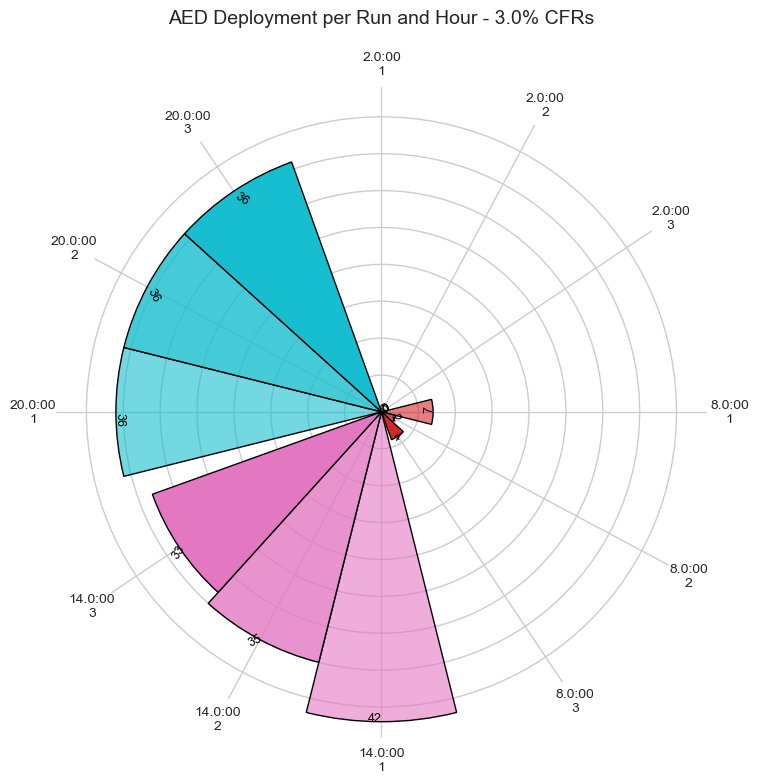

In [90]:
hours = [2.0, 8.0, 14.0, 20.0]
prop = 0.03
style = "aedYes"
radial_bar_aeds_by_hour(hours, prop, style, all_data)

In [91]:
df_test = all_data[(8.0, 0.0175, "aedYes")]
print(round((len(df_test[df_test["aed_loc_run1"]!="No AED"]) + len(df_test[df_test["aed_loc_run2"]!="No AED"]) + len(df_test[df_test["aed_loc_run3"]!="No AED"]))/3))

print(f'first run: {len(df_test[df_test["aed_loc_run1"]!="No AED"])}')
print(f'second run: {len(df_test[df_test["aed_loc_run2"]!="No AED"])}')
print(f'third run: {len(df_test[df_test["aed_loc_run3"]!="No AED"])}')

12
first run: 12
second run: 15
third run: 9


In [ ]:
means_vec = [df_1["prob_vec_run1"].mean(), df_1["prob_vec_run2"].mean(),df_1["prob_vec_run3"].mean()]
# means_resp = [df_1["prob_resp_run1"].mean(), df_1["prob_resp_run2"].mean(),df_1["prob_resp_run3"].mean()]
# means_resp_2 = [df_1_2["prob_resp_run1"].mean(), df_1_2["prob_resp_run2"].mean(),df_1_2["prob_resp_run3"].mean()]
# means_resp_8 = [df_2["prob_resp_run1"].mean(), df_2["prob_resp_run2"].mean(),df_2["prob_resp_run3"].mean()]
# means_resp_8_2 = [df_2_2["prob_resp_run1"].mean(), df_2_2["prob_resp_run2"].mean(),df_2_2["prob_resp_run3"].mean()]
# means_resp_20 = [df_4["prob_resp_run1"].mean(), df_4["prob_resp_run2"].mean(),df_4["prob_resp_run3"].mean()]
# means_resp_20_2 = [df_4_2["prob_resp_run1"].mean(), df_4_2["prob_resp_run2"].mean(),df_4_2["prob_resp_run3"].mean()]

means_resp = (df_1["prob_resp_run1"].mean()+ df_1["prob_resp_run2"].mean()+df_1["prob_resp_run3"].mean())/3
means_resp_2 = (df_1_2["prob_resp_run1"].mean() + df_1_2["prob_resp_run2"].mean()+df_1_2["prob_resp_run3"].mean())/3
means_resp_8 = (df_2["prob_resp_run1"].mean()+ df_2["prob_resp_run2"].mean()+df_2["prob_resp_run3"].mean())/3
means_resp_8_2 = (df_2_2["prob_resp_run1"].mean()+ df_2_2["prob_resp_run2"].mean()+df_2_2["prob_resp_run3"].mean())/3
means_resp_14 = (df_3["prob_resp_run1"].mean()+ df_3["prob_resp_run2"].mean()+df_3["prob_resp_run3"].mean())/3
means_resp_14_2 = (df_3_2["prob_resp_run1"].mean()+ df_3_2["prob_resp_run2"].mean()+df_3_2["prob_resp_run3"].mean())/3
means_resp_20 = (df_4["prob_resp_run1"].mean()+ df_4["prob_resp_run2"].mean()+df_4["prob_resp_run3"].mean())/3
means_resp_20_2 = (df_4_2["prob_resp_run1"].mean()+ df_4_2["prob_resp_run2"].mean()+df_4_2["prob_resp_run3"].mean())/3

means_resp_075 = (df_1_075["prob_resp_run1"].mean()+ df_1_075["prob_resp_run2"].mean()+df_1_075["prob_resp_run3"].mean())/3
means_resp_001 = (df_1_001["prob_resp_run1"].mean() + df_1_001["prob_resp_run2"].mean()+df_1_001["prob_resp_run3"].mean())/3
means_resp_8_075 = (df_2_075["prob_resp_run1"].mean()+ df_2_075["prob_resp_run2"].mean()+df_2_075["prob_resp_run3"].mean())/3
means_resp_8_001 = (df_2_001["prob_resp_run1"].mean()+ df_2_001["prob_resp_run2"].mean()+df_2_001["prob_resp_run3"].mean())/3
means_resp_14_075 = (df_3_075["prob_resp_run1"].mean()+ df_3_075["prob_resp_run2"].mean()+df_3_075["prob_resp_run3"].mean())/3
means_resp_14_001 = (df_3_001["prob_resp_run1"].mean()+ df_3_001["prob_resp_run2"].mean()+df_3_001["prob_resp_run3"].mean())/3
means_resp_20_075 = (df_4_075["prob_resp_run1"].mean()+ df_4_075["prob_resp_run2"].mean()+df_4_075["prob_resp_run3"].mean())/3
means_resp_20_001 = (df_4_001["prob_resp_run1"].mean()+ df_4_001["prob_resp_run2"].mean()+df_4_001["prob_resp_run3"].mean())/3

In [26]:
print(f'CFR 1.75% survival at 2 a.m.: {means_resp}')
print(f'CFR 2% survival at 2 a.m.:{means_resp_2}')
print(f'CFR 0.75% survival at 2 a.m.: {means_resp_075}')
print(f'CFR 0.1% survival at 2 a.m.:{means_resp_001}')
print(f'CFR 1.75% survival at 8 a.m.:{means_resp_8}')
print(f'CFR 2% survival at 8 a.m.:{means_resp_8_2}')
print(f'CFR 0.75% survival at 2 a.m.: {means_resp_8_075}')
print(f'CFR 0.1% survival at 2 a.m.:{means_resp_8_001}')
print(f'CFR 1.75% survival at 2 p.m.:{means_resp_14}')
print(f'CFR 2% survival at 2 p.m.:{means_resp_14_2}')
print(f'CFR 0.75% survival at 2 a.m.: {means_resp_14_075}')
print(f'CFR 0.1% survival at 2 a.m.:{means_resp_14_001}')
print(f'CFR 1.75% survival at 8 p.m.:{means_resp_20}')
print(f'CFR 2% survival at 8 p.m.:{means_resp_20_2}')
print(f'CFR 0.75% survival at 2 a.m.: {means_resp_20_075}')
print(f'CFR 0.1% survival at 2 a.m.:{means_resp_20_001}')

CFR 1.75% survival at 2 a.m.: 0.44073047613585264
CFR 2% survival at 2 a.m.:0.4435332264885026
CFR 0.75% survival at 2 a.m.: 0.4043017878720155
CFR 0.1% survival at 2 a.m.:0.2927966068660371
CFR 1.75% survival at 8 a.m.:0.43288860969415605
CFR 2% survival at 8 a.m.:0.43599321054780543
CFR 0.75% survival at 2 a.m.: 0.40295512141991985
CFR 0.1% survival at 2 a.m.:0.29080736498181853
CFR 1.75% survival at 2 p.m.:0.3936214979367522
CFR 2% survival at 2 p.m.:0.39841737256272913
CFR 0.75% survival at 2 a.m.: 0.3598895874944894
CFR 0.1% survival at 2 a.m.:0.2768970412807081
CFR 1.75% survival at 8 p.m.:0.4134355321254448
CFR 2% survival at 8 p.m.:0.4157889008966778
CFR 0.75% survival at 2 a.m.: 0.38561604307832287
CFR 0.1% survival at 2 a.m.:0.28932271956032674


In [33]:
df_075perc_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1164 entries, 0 to 1163
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_loc                  1164 non-null   object 
 1   responder_loc_run1           388 non-null    object 
 2   duration_Responder_run1      388 non-null    float64
 3   Indirect_Responder_loc_run1  388 non-null    object 
 4   aed_loc_run1                 388 non-null    object 
 5   duration_AED_run1            388 non-null    float64
 6   vector_loc_run1              388 non-null    object 
 7   duration_Vector_run1         388 non-null    float64
 8   prob_vec_run1                388 non-null    float64
 9   prob_resp_run1               388 non-null    float64
 10  filter_values_run1           388 non-null    object 
 11  opening_hour_run1            388 non-null    float64
 12  decline_rate_run1            388 non-null    float64
 13  max_number_respond

In [126]:
import pandas as pd

# List of your original DataFrames
df_names = [
    "df_175perc_2", "df_175perc_8", "df_175perc_14", "df_175perc_20",
    "df_2perc_2", "df_2perc_8", "df_2perc_14", "df_2perc_20",
    "df_075perc_2", "df_075perc_8", "df_075perc_14", "df_075perc_20",
    "df_01perc_2", "df_01perc_8", "df_01perc_14", "df_01perc_20"
]

# Dictionary to hold processed DataFrames
processed_dfs = {}

for name in df_names:
    df = globals()[name]

    # Split the DataFrame into three parts
    df_run1 = df.iloc[0:388].reset_index(drop=True)
    cols_to_drop_1 = [col for col in df_run1.columns if col.endswith('_run2') or col.endswith('_run3')]
    df_run1 = df_run1.drop(columns=cols_to_drop_1)
    df_run2 = df.iloc[388:776].reset_index(drop=True)
    cols_to_drop_2 = [col for col in df_run2.columns if col.endswith('_run1') or col.endswith('_run3')]
    df_run2 = df_run2.drop(columns=cols_to_drop_2)
    df_run3 = df.iloc[776:1164].reset_index(drop=True)
    cols_to_drop_3 = [col for col in df_run3.columns if col.endswith('_run1') or col.endswith('_run2')]
    df_run3 = df_run3.drop(columns=cols_to_drop_3)

    # Standardize patient_loc as string for consistent merging
    for d in [df_run1, df_run2, df_run3]:
        d["patient_loc"] = d["patient_loc"].astype(str).str.strip()

    # Merge on patient_loc using outer structure: run1 base, fill in from 2 and 3
    df_merged = df_run1.merge(df_run2, on="patient_loc", how="outer")
    df_merged = df_merged.merge(df_run3, on="patient_loc", how="outer")

    df_merged["avg_resp_prob"] = (df_merged["prob_resp_run1"] + df_merged["prob_resp_run2"] +df_merged["prob_resp_run3"])/3
    

    processed_dfs[f"{name}_processed"] = df_merged

In [127]:
df_test = processed_dfs["df_175perc_2_processed"]


In [128]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_loc                  388 non-null    object 
 1   responder_loc_run1           388 non-null    object 
 2   duration_Responder_run1      388 non-null    float64
 3   Indirect_Responder_loc_run1  388 non-null    object 
 4   aed_loc_run1                 388 non-null    object 
 5   duration_AED_run1            388 non-null    float64
 6   vector_loc_run1              388 non-null    object 
 7   duration_Vector_run1         388 non-null    float64
 8   prob_vec_run1                388 non-null    float64
 9   prob_resp_run1               388 non-null    float64
 10  filter_values_run1           388 non-null    object 
 11  opening_hour_run1            388 non-null    float64
 12  decline_rate_run1            388 non-null    float64
 13  max_number_responder

In [129]:
processed_dfs["df_175perc_2_processed"]

,patient_loc,responder_loc_run1,duration_Responder_run1,Indirect_Responder_loc_run1,aed_loc_run1,duration_AED_run1,vector_loc_run1,duration_Vector_run1,prob_vec_run1,prob_resp_run1,...,vector_loc_run3,duration_Vector_run3,prob_vec_run3,prob_resp_run3,filter_values_run3,opening_hour_run3,decline_rate_run3,max_number_responder_run3,proportion_of_CFR_run3,avg_resp_prob
0,"(4.724486, 50.875134)","(4.7255504936947705, 50.875174958221535)",67.27,No AED,No AED,10000.0,"(4.7243436, 50.8696549)",641.37,0.324247,0.663935,...,"(4.7243436, 50.8696549)",641.37,0.324247,0.629204,Yes,2.0,0.75,100.0,0.0175,0.670873
1,"(4.663458, 50.872624)","(4.664529595769382, 50.8743763982888)",191.77,No AED,No AED,10000.0,"(4.6658621, 50.8774603)",621.19,0.335943,0.574218,...,"(4.6658621, 50.8774603)",621.19,0.335943,0.629696,Yes,2.0,0.75,100.0,0.0175,0.611080
2,"(4.706287, 50.868107)","(4.706874089551423, 50.86924770970929)",121.04,No AED,No AED,10000.0,"(4.6998331, 50.8723536)",618.41,0.337587,0.628111,...,"(4.6998331, 50.8723536)",618.41,0.337587,0.595380,Yes,2.0,0.75,100.0,0.0175,0.616108
3,"(4.729334, 50.886379)","(4.730891531604586, 50.8878937997785)",198.37,No AED,No AED,10000.0,"(4.7243436, 50.8696549)",1978.53,0.030983,0.285920,...,"(4.7243436, 50.8696549)",1978.53,0.030983,0.296560,Yes,2.0,0.75,100.0,0.0175,0.281106
4,"(4.7093, 50.870361)","(4.7095735012402935, 50.87032585061185)",12.37,No AED,No AED,10000.0,"(4.6998331, 50.8723536)",750.80,0.267560,0.672611,...,"(4.6998331, 50.8723536)",750.80,0.267560,0.670959,Yes,2.0,0.75,100.0,0.0175,0.664756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,"(4.692054, 50.883744)","(4.691749072650227, 50.88424442422316)",49.03,No AED,No AED,10000.0,"(4.6953981, 50.8785355)",612.09,0.341354,0.689398,...,"(4.6953981, 50.8785355)",612.09,0.341354,0.649602,Yes,2.0,0.75,100.0,0.0175,0.666421
384,"(4.676329, 50.867263)","(4.677793078683198, 50.86683970794308)",113.50,No AED,No AED,10000.0,"(4.6658621, 50.8774603)",1466.98,0.076075,0.412134,...,"(4.6658621, 50.8774603)",1466.98,0.076075,0.284672,Yes,2.0,0.75,100.0,0.0175,0.365722
385,"(4.676351, 50.870025)","(4.675453572970399, 50.86937587476233)",107.20,No AED,No AED,10000.0,"(4.6658621, 50.8774603)",934.56,0.193768,0.544299,...,"(4.6658621, 50.8774603)",934.56,0.193768,0.584441,Yes,2.0,0.75,100.0,0.0175,0.555608
386,"(4.71405, 50.873746)","(4.714021861594397, 50.874124956729645)",28.78,No AED,No AED,10000.0,"(4.7243436, 50.8696549)",693.89,0.295680,0.678288,...,"(4.7243436, 50.8696549)",693.89,0.295680,0.600040,Yes,2.0,0.75,100.0,0.0175,0.646352


In [130]:
df_175_2

NameError: name 'df_175_2' is not defined

In [131]:
def violin_plot(datasets):
    data = []
    labels = []

    for label, df in datasets.items():
        # Convert to numpy array, flatten, and ensure numeric
        values = pd.to_numeric(np.array(df["avg_resp_prob"]).flatten(), errors='coerce')  # coerce turns bad data into NaN
        values = values[~np.isnan(values)]  # remove NaNs
        
        if len(values) == 0:
            print(f"Warning: Dataset '{label}' is empty after filtering.")
            continue

        data.append(values)
        labels.append(label)

    plt.figure(figsize=(10, 6))
    plt.violinplot(data, showmeans=True, showmedians=True)
    plt.xticks(ticks=np.arange(1, len(labels) + 1), labels=labels, rotation=30)
    plt.title("Frequencies of survival rate")
    plt.ylabel("Out of hospital survival rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

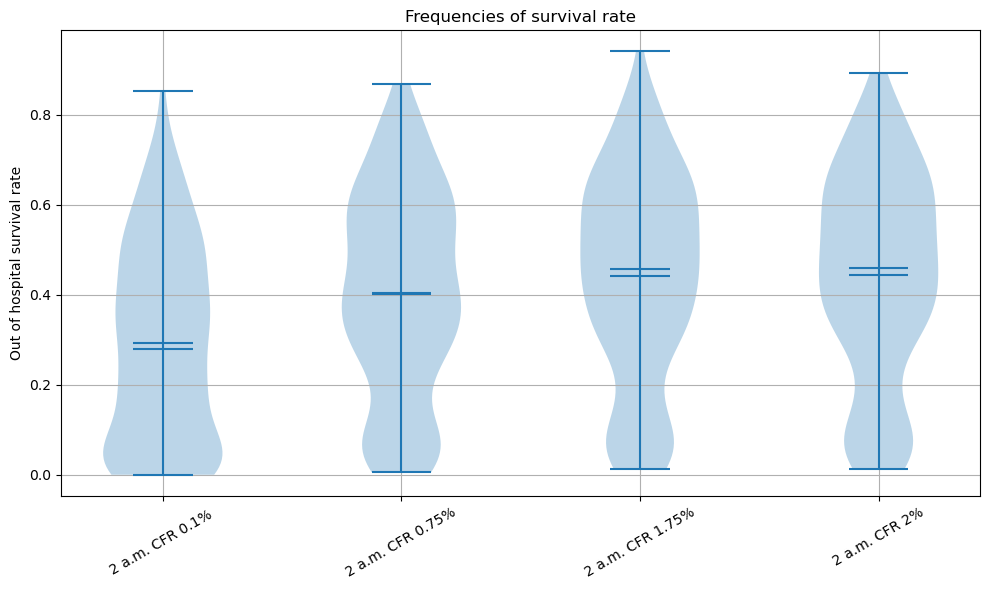

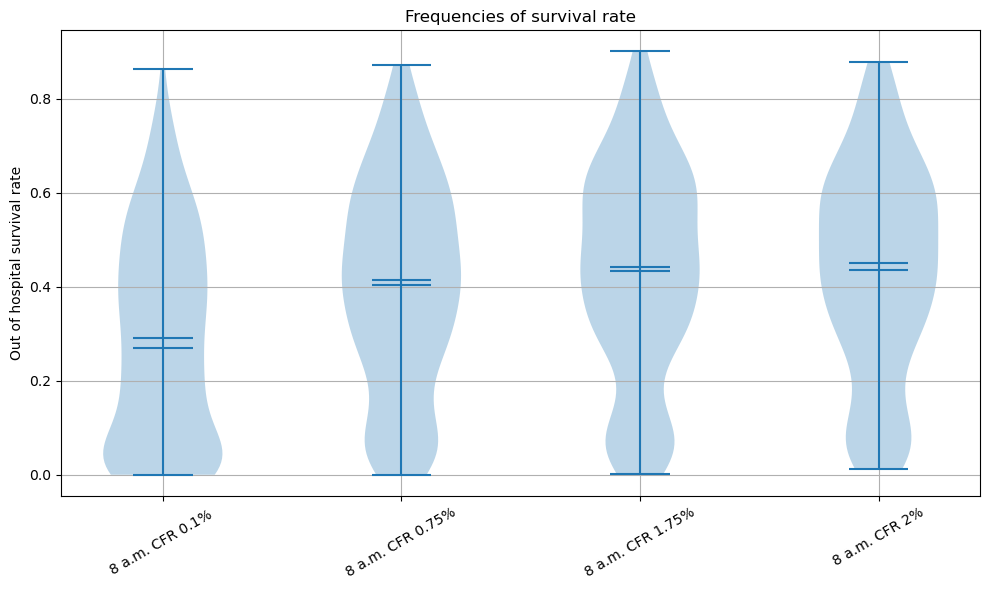

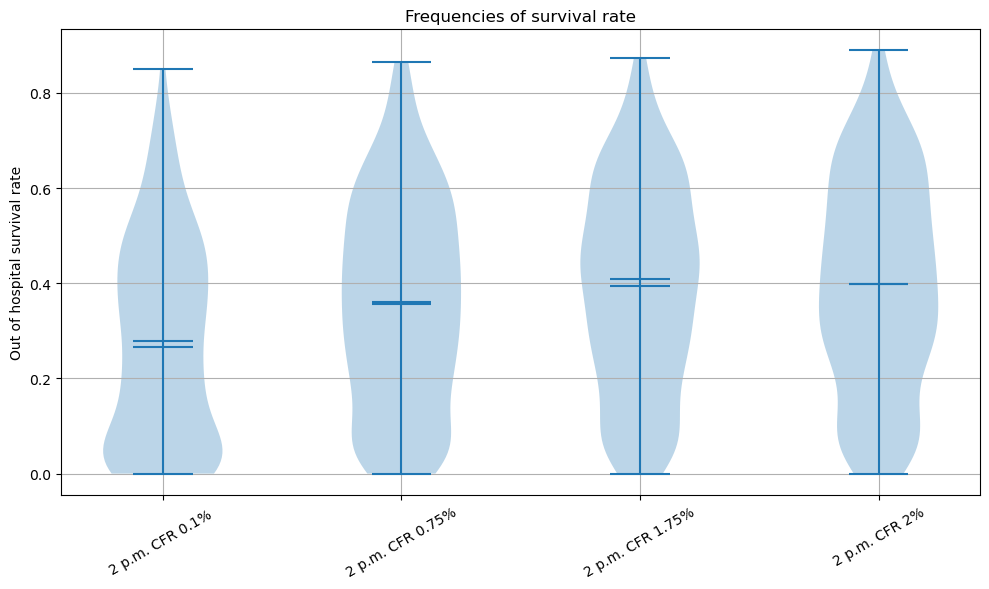

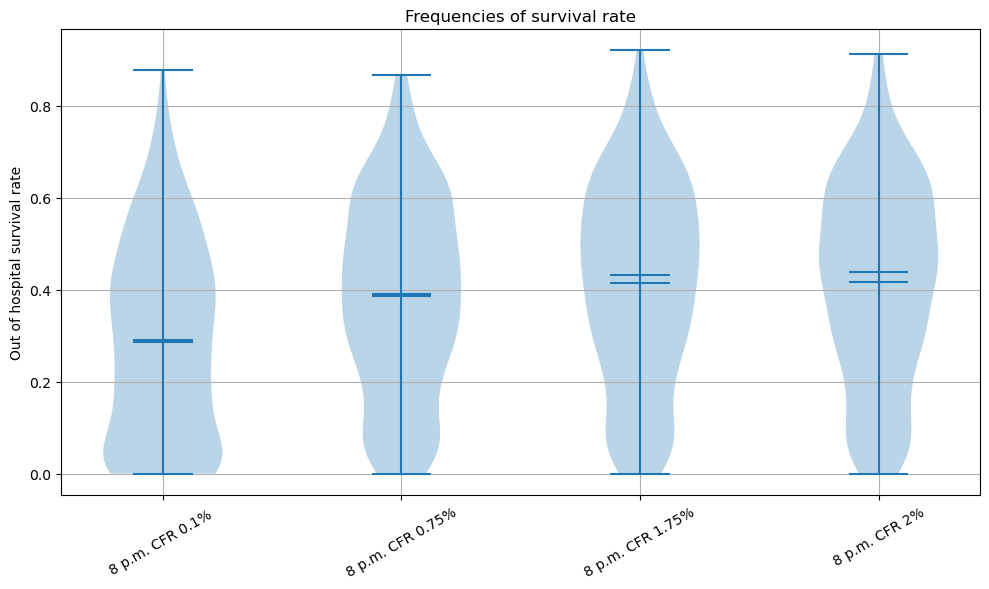

In [134]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

datasets_2 = {
     "2 a.m. CFR 0.1% ": processed_dfs["df_01perc_2_processed"],
     "2 a.m. CFR 0.75%": processed_dfs["df_075perc_2_processed"],
     "2 a.m. CFR 1.75%": processed_dfs["df_175perc_2_processed"],
     "2 a.m. CFR 2%": processed_dfs["df_2perc_2_processed"],
}

datasets_8 = {
     "8 a.m. CFR 0.1% ": processed_dfs["df_01perc_8_processed"],
     "8 a.m. CFR 0.75%": processed_dfs["df_075perc_8_processed"],
     "8 a.m. CFR 1.75%": processed_dfs["df_175perc_8_processed"],
     "8 a.m. CFR 2%": processed_dfs["df_2perc_8_processed"],
}

datasets_14 = {
     "2 p.m. CFR 0.1% ": processed_dfs["df_01perc_14_processed"],
     "2 p.m. CFR 0.75%": processed_dfs["df_075perc_14_processed"],
     "2 p.m. CFR 1.75%": processed_dfs["df_175perc_14_processed"],
     "2 p.m. CFR 2%": processed_dfs["df_2perc_14_processed"],
}

datasets_20 = {
     "8 p.m. CFR 0.1% ": processed_dfs["df_01perc_20_processed"],
     "8 p.m. CFR 0.75%": processed_dfs["df_075perc_20_processed"],
     "8 p.m. CFR 1.75%": processed_dfs["df_175perc_20_processed"],
     "8 p.m. CFR 2%": processed_dfs["df_2perc_20_processed"],
}


violin_plot(datasets_2)
violin_plot(datasets_8)
violin_plot(datasets_14)
violin_plot(datasets_20)

In [50]:
df_test

,patient_loc,responder_loc_run1,duration_Responder_run1,Indirect_Responder_loc_run1,aed_loc_run1,duration_AED_run1,vector_loc_run1,duration_Vector_run1,prob_vec_run1,prob_resp_run1,...,duration_AED_run3,vector_loc_run3,duration_Vector_run3,prob_vec_run3,prob_resp_run3,filter_values_run3,opening_hour_run3,decline_rate_run3,max_number_responder_run3,proportion_of_CFR_run3
0,"(4.724486, 50.875134)","(4.7255504936947705, 50.875174958221535)",67.27,No AED,No AED,10000.0,"(4.7243436, 50.8696549)",641.37,0.324247,0.663935,...,10000.0,"(4.7243436, 50.8696549)",641.37,0.324247,0.629204,Yes,2.0,0.75,100.0,0.0175
1,"(4.663458, 50.872624)","(4.664529595769382, 50.8743763982888)",191.77,No AED,No AED,10000.0,"(4.6658621, 50.8774603)",621.19,0.335943,0.574218,...,10000.0,"(4.6658621, 50.8774603)",621.19,0.335943,0.629696,Yes,2.0,0.75,100.0,0.0175
2,"(4.706287, 50.868107)","(4.706874089551423, 50.86924770970929)",121.04,No AED,No AED,10000.0,"(4.6998331, 50.8723536)",618.41,0.337587,0.628111,...,10000.0,"(4.6998331, 50.8723536)",618.41,0.337587,0.595380,Yes,2.0,0.75,100.0,0.0175
3,"(4.729334, 50.886379)","(4.730891531604586, 50.8878937997785)",198.37,No AED,No AED,10000.0,"(4.7243436, 50.8696549)",1978.53,0.030983,0.285920,...,10000.0,"(4.7243436, 50.8696549)",1978.53,0.030983,0.296560,Yes,2.0,0.75,100.0,0.0175
4,"(4.7093, 50.870361)","(4.7095735012402935, 50.87032585061185)",12.37,No AED,No AED,10000.0,"(4.6998331, 50.8723536)",750.80,0.267560,0.672611,...,10000.0,"(4.6998331, 50.8723536)",750.80,0.267560,0.670959,Yes,2.0,0.75,100.0,0.0175


In [84]:
df_test = processed_dfs["df_175perc_2_processed"]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   patient_loc                  388 non-null    object 
 1   responder_loc_run1           388 non-null    object 
 2   duration_Responder_run1      388 non-null    float64
 3   Indirect_Responder_loc_run1  388 non-null    object 
 4   aed_loc_run1                 388 non-null    object 
 5   duration_AED_run1            388 non-null    float64
 6   vector_loc_run1              388 non-null    object 
 7   duration_Vector_run1         388 non-null    float64
 8   prob_vec_run1                388 non-null    float64
 9   prob_resp_run1               388 non-null    float64
 10  filter_values_run1           388 non-null    object 
 11  opening_hour_run1            388 non-null    float64
 12  decline_rate_run1            388 non-null    float64
 13  max_number_responder

In [72]:
type(df_test.loc[0,"aed_loc_run3"])

str

In [59]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import openrouteservice

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Own Classes
from Simulation_Routing import *
from Simulating import *
from Simulation_Routing_Matrix import *
from Simulation_Routing_Matrix_copy import *
from Simulation_Routing_Matrix_Batch import *
from tqdm import tqdm
import json
from geojson import Feature, FeatureCollection, LineString

In [61]:
from geojson import Feature, FeatureCollection, LineString

In [60]:
IP = "35.159.16.25"
CLIENT_ORS = openrouteservice.Client(base_url=f'http://{IP}:8080/ors')

In [85]:

def __directions(CLIENT_ORS, coordinates, profile='foot-walking'):
    route = CLIENT_ORS.directions(
        coordinates=coordinates,
        profile=profile,
        format='geojson',
        validate=False
    )

    return {
        'coordinates': route.get('features')[0]['geometry']['coordinates']
    }
import ast
from geojson import Feature, FeatureCollection
from shapely.geometry import LineString



def is_coord_string(x):
    # Check for typical coordinate-like string e.g., "(4.45, 50.85)"
    return isinstance(x, str) and x.startswith("(") and x.endswith(")")

def heatmap_data(CLIENT_ORS, df, profile='foot-walking'):
    # Convert coordinate strings to list, skip non-coordinate entries like "No AED"
    location_columns = [col for col in df.columns if col.endswith("_loc") or "_loc_" in col]
    for col in location_columns:
        df[col] = df[col].apply(
            lambda x: list(ast.literal_eval(x)) if is_coord_string(x) else x
        )

    features = []

    for _, row in df.iterrows():
        patient = row["patient_loc"]

        run_data = [
            (row["aed_loc_run1"], row["responder_loc_run1"]),
            (row["aed_loc_run2"], row["responder_loc_run2"]),
            (row["aed_loc_run3"], row["responder_loc_run3"])
        ]

        for aed, responder in run_data:
            if isinstance(responder, (tuple, list)):
                coordinates = [patient]
                if isinstance(aed, (tuple, list)):
                    coordinates.append(aed)
                coordinates.append(responder)

                route = __directions(CLIENT_ORS, coordinates, profile=profile)
                line = LineString(route["coordinates"])
                features.append(Feature(geometry=line, properties={}))

    return FeatureCollection(features)

In [86]:
import folium

geojson_data = heatmap_data(CLIENT_ORS, df_test)

# Center the map roughly around your data
m = folium.Map(location=[50.85, 4.35], zoom_start=13)

# Add the routes as GeoJSON lines
folium.GeoJson(geojson_data, name="routes").add_to(m)

# Display or save map
m.save("routes_map.html")

In [112]:
from collections import defaultdict
import folium

def route_frequencies(feature_collection):
    freq = defaultdict(int)

    for feature in feature_collection["features"]:
        coords = tuple(map(tuple, feature["geometry"]["coordinates"]))  # freeze for hashing
        freq[coords] += 1

    return freq

def visualize_weighted_routes(freq_dict):
    m = folium.Map(location=[50.85, 4.35], zoom_start=13)

    max_freq = max(freq_dict.values())

    for coords, count in freq_dict.items():
        # Convert back to lat/lon
        coords_latlon = [(lat, lon) for lon, lat in coords]

        # Normalize weight (thicker if used more)
        weight = 0.1 + 2 * (count / max_freq)

        folium.PolyLine(
            locations=coords_latlon,
            color='red',
            weight=weight,
            opacity=0.6
        ).add_to(m)

    return m

In [113]:
freq = route_frequencies(geojson_data)
m = visualize_weighted_routes(freq)
m.save("routes.html")

In [122]:
import pydeck as pdk
from collections import defaultdict

# --- Step 1: Count route frequencies ---
def route_frequencies(feature_collection):
    freq = defaultdict(int)
    for feature in feature_collection["features"]:
        coords = tuple(map(tuple, feature["geometry"]["coordinates"]))
        freq[coords] += 1
    return freq

# --- Step 2: Prepare data for Pydeck ---
def prepare_pydeck_data(freq_dict):
    max_freq = max(freq_dict.values())
    lines = []

    for coords, count in freq_dict.items():
        lines.append({
            "path": list(coords),
            "frequency": count,
            "width": 0.1 + 1 * (count / max_freq),  # Scaled width
            "color": [255, 0, 0, int(80 + 175 * (count / max_freq))]  # Alpha for glow
        })

    return lines

# --- Step 3: Visualize ---
def visualize_routes_pydeck(feature_collection):
    freq_dict = route_frequencies(feature_collection)
    lines = prepare_pydeck_data(freq_dict)

    layer = pdk.Layer(
        "PathLayer",
        lines,
        get_path="path",
        get_width="width",
        get_color="color",
        width_scale=10,
        width_min_pixels=1,
        pickable=False
    )

    view_state = pdk.ViewState(
        latitude=50.88,
        longitude=4.70,
        zoom=13,
        pitch=0,
        bearing=0
    )

    deck = pdk.Deck(
        layers=[layer],
        initial_view_state=view_state,
        map_style="dark_no_labels",
        tooltip={"text": "Frequency: {frequency}"}
    )

    return deck

# --- Run it ---
deck = visualize_routes_pydeck(geojson_data)
deck.show()

DeckGLWidget(carto_key=None, custom_libraries=[], google_maps_key=None, json_input='{\n  "initialViewState": {…